# Kaggle RSNA Intracranial Haemhorrhage

This notebook is the first in a series breaking down the **2nd place solution and code by team NoBrainer** for the Kaggle RSNA Intracranial Haemhorrhage competition. To check out their own code and explainers have a look at these links:

- [Kaggle discussion of their solution](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/117228)
- [Accompanying Youtube explainer](https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/117228)
- [Code on Github](https://github.com/darraghdog/rsna)

## Data Prepartion
This first notebook covers the Data Preparation
- Loading from DICOM files
- Rescaling 
- Windowing
- DICOM to JPEG  

In [4]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import torch
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
sys.path.insert(0, 'scripts')
from logs import get_logger, dumpobj, loadobj

In [5]:
# Print info about environments
logger = get_logger('Prepare Data', 'INFO') # noqa
logger.info('Cuda set up : time {}'.format(datetime.datetime.now().time()))

def get_dicom_value(x, cast=int):
    if type(x) in [pydicom.multival.MultiValue, tuple]:
        return cast(x[0])
    else:
        return cast(x)

def cast(value):
    if type(value) is pydicom.valuerep.MultiValue:
        return tuple(value)
    return value

def get_dicom_raw(dicom):
    return {attr:cast(getattr(dicom,attr)) for attr in dir(dicom) if attr[0].isupper() and attr not in ['PixelData']}

def rescale_image(image, slope, intercept):
    return image * slope + intercept

def apply_window(image, center, width):
    image = image.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return image

def apply_window_policy(image):
    
    # Return windowed images
    image1 = apply_window(image, 40, 80) # brain
    image2 = apply_window(image, 80, 200) # subdural
    image3 = apply_window(image, 40, 380) # bone
    
    # Min-Max Normalise the pixel values
    # y= (x-min)/(max-min)
    
    image1 = (image1 - 0) / 80
    image2 = (image2 - (-20)) / 200
    image3 = (image3 - (-150)) / 380
   
    # Concat the 3 windows to create a sinlge, 3-channel image
    # Appian actually mentioned in a comment here:
    # https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/112819 
    # that this code below was a mistake and should have been:
    # image = np.array([image1,image2, image3,]).transpose(1,2,0)
    
    image = np.array([
        image1 - image1.mean(),
        image2 - image2.mean(),
        image3 - image3.mean(),
    ]).transpose(1,2,0)

    return image

def get_dicom_meta(dicom):
    return {
        'PatientID': dicom.PatientID, # can be grouped (20-548)
        'StudyInstanceUID': dicom.StudyInstanceUID, # can be grouped (20-60)
        'SeriesInstanceUID': dicom.SeriesInstanceUID, # can be grouped (20-60)
        'WindowWidth': get_dicom_value(dicom.WindowWidth),
        'WindowCenter': get_dicom_value(dicom.WindowCenter),
        'RescaleIntercept': float(dicom.RescaleIntercept),
        'RescaleSlope': float(dicom.RescaleSlope), # all same (1.0)
    }

def convert_dicom_to_jpg(name):
    try:
        dirtype = 'train' if 'train' in n else 'test'
        imgnm = (n.split('/')[-1]).replace('.dcm', '')
        dicom = pydicom.dcmread(n) #DicomBytesIO(data))
        image = dicom.pixel_array
        
        # Return rescaled image pixel values
        image = rescale_image(image, 
                              rescaledict['RescaleSlope'][imgnm], 
                              rescaledict['RescaleIntercept'][imgnm])
        
        # Return 3-channel windowed images
        image = apply_window_policy(image)
        
        image -= image.min((0,1))
        image = (255*image).astype(np.uint8)
        imgnmf = dirtype + '_' + imgnm
        cv2.imwrite(os.path.join(PATHPROC, imgnmf)+'.jpg', image)
    except:
        logger.info(name)     

2020-01-20 20:37:57,707 - Prepare Data - INFO - Cuda set up : time 20:37:57.706993


## Generate Metadata DF
Generate the metadata dataframes

In [6]:
def generate_df(base, files):
    train_di = {}

    for filename in tqdm(files):
        path = os.path.join( base ,  filename)
        dcm = pydicom.dcmread(path)
        all_keywords = dcm.dir()
        ignored = ['Rows', 'Columns', 'PixelData']

        for name in all_keywords:
            if name in ignored:
                continue

            if name not in train_di:
                train_di[name] = []

            train_di[name].append(dcm[name].value)

    df = pd.DataFrame(train_di)
    
    return df

In [7]:
DATAPATH = 'data'
TRAIN_DIR = os.path.join(DATAPATH, 'rsna-intracranial-hemorrhage-detection/stage_2_train')
TEST_DIR = os.path.join(DATAPATH, 'rsna-intracranial-hemorrhage-detection/stage_2_test')
PATHPROC = os.path.join(DATAPATH, 'rsna_darraghdog/darraghdog_proc')

In [8]:
logger.info('Create test meta files')
test_files = os.listdir(TEST_DIR)
test_df = generate_df(TEST_DIR, test_files)
test_df.to_csv(os.path.join(DATAPATH, 'darraghdog_test_metadata.csv'))

2020-01-20 20:38:08,140 - Prepare Data - INFO - Create test meta files
100%|██████████| 121232/121232 [03:12<00:00, 631.30it/s]


In [9]:
test_df.head()

,BitsAllocated,BitsStored,HighBit,ImageOrientationPatient,ImagePositionPatient,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth
0,16,16,15,"[1.000000, 0.000000, 0.000000, 0.000000, 0.936...","[-125.000000, -112.984024, 95.907135]",CT,ID_79cdc6e4,MONOCHROME2,1,"[0.488281, 0.488281]",-1024.0,1.0,ID_1f3cb298e,1,ID_01c388cfe3,,ID_07c298b5be,30,80
1,16,12,11,"[1, 0, 0, 0, 1, 0]","[-115.5, 8.5, 213.299927]",CT,ID_ea651384,MONOCHROME2,0,"[0.451171875, 0.451171875]",-1024.0,1.0,ID_4f8d77016,1,ID_310f757e9c,,ID_ad2155a27f,"[00036, 00036]","[00080, 00080]"
2,16,12,11,"[1, 0, 0, 0, 1, 0]","[-118, -6, 194.900024]",CT,ID_d00a0fde,MONOCHROME2,0,"[0.4609375, 0.4609375]",-1024.0,1.0,ID_9ed31a4ea,1,ID_f4a8788e99,,ID_032ec08968,"[00036, 00036]","[00080, 00080]"
3,16,16,15,"[1.000000, 0.000000, 0.000000, 0.000000, 0.963...","[-125.000, -133.354, 140.517]",CT,ID_2a82dbbb,MONOCHROME2,1,"[0.488281, 0.488281]",-1024.0,1.0,ID_55374b6fb,1,ID_f633feed75,,ID_636f076199,40,150
4,16,12,11,"[1, 0, 0, 0, 0.994521895, -0.104528463]","[-125, -26.8622189, 167.929303]",CT,ID_f86f7107,MONOCHROME2,0,"[0.48828125, 0.48828125]",-1024.0,1.0,ID_11fcc7602,1,ID_d021858530,,ID_5d4b24326f,"[00040, 00040]","[00080, 00080]"


In [6]:
logger.info('Create train meta files')
train_files = os.listdir(TRAIN_DIR)
train_df = generate_df(TRAIN_DIR, train_files)
train_df.to_csv(os.path.join(DATAPATH, 'rsna_darraghdog/darraghdog_train_metadata.csv'))

2020-01-09 19:42:19,280 - Prepare Data - INFO - Create train meta files
100%|██████████| 752803/752803 [19:29<00:00, 643.96it/s]  


In [7]:
train_df.head()

,BitsAllocated,BitsStored,HighBit,ImageOrientationPatient,ImagePositionPatient,Modality,PatientID,PhotometricInterpretation,PixelRepresentation,PixelSpacing,RescaleIntercept,RescaleSlope,SOPInstanceUID,SamplesPerPixel,SeriesInstanceUID,StudyID,StudyInstanceUID,WindowCenter,WindowWidth
0,16,16,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[-125.000, -144.700, 109.750]",CT,ID_4b0046ad,MONOCHROME2,1,"[0.488281, 0.488281]",-1024.0,1.0,ID_ab886fada,1,ID_09d4f377c7,,ID_e89436d023,40,150
1,16,16,15,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[-125.000, -157.000, -12.500]",CT,ID_c2c5d69b,MONOCHROME2,1,"[0.488281, 0.488281]",-1024.0,1.0,ID_99925976a,1,ID_e55c2acbf3,,ID_b4e4ae168f,40,150
2,16,12,11,"[1, 0, 0, 0, 1, 0]","[-125, 13, 149.699951]",CT,ID_0d3ef9d2,MONOCHROME2,0,"[0.48828125, 0.48828125]",-1024.0,1.0,ID_215288b2e,1,ID_eaa83ed791,,ID_351a11452f,"[00036, 00036]","[00080, 00080]"
3,16,12,11,"[1, 0, 0, 0, 1, 0]","[-125, -8, 89.8000488]",CT,ID_6ae9cf01,MONOCHROME2,0,"[0.48828125, 0.48828125]",-1024.0,1.0,ID_55a71680c,1,ID_50ee0e5d7c,,ID_aeec8f26e5,"[00036, 00036]","[00080, 00080]"
4,16,12,11,"[1, 0, 0, 0, 0.974370065, -0.224951054]","[-125, -29.54624, 155.704763]",CT,ID_97e2ec20,MONOCHROME2,0,"[0.48828125, 0.48828125]",-1024.0,1.0,ID_579eba2cb,1,ID_cdd43a9610,,ID_2e3fbc4894,"[00047, 00047]","[00080, 00080]"


Load the dataframes just created

In [8]:
logger.info('Load meta files')
trnmdf = pd.read_csv(os.path.join(DATAPATH, 'rsna_darraghdog/darraghdog_train_metadata.csv'))
logger.info('Train meta shape {} {}'.format(*trnmdf.shape))

tstmdf = pd.read_csv(os.path.join(DATAPATH, 'rsna_darraghdog/darraghdog_test_metadata.csv'))
logger.info('Test  meta shape {} {}'.format(*tstmdf.shape))

mdf = pd.concat([trnmdf, tstmdf], 0)
rescaledict = mdf.set_index('SOPInstanceUID')[['RescaleSlope', 'RescaleIntercept']].to_dict()

2020-01-09 20:02:08,336 - Prepare Data - INFO - Load meta files
2020-01-09 20:02:10,848 - Prepare Data - INFO - Train meta shape 752803 20
2020-01-09 20:02:11,183 - Prepare Data - INFO - Test  meta shape 121232 20


In [10]:
rescaledict

{'RescaleSlope': {'ID_ab886fada': 1.0,
  'ID_99925976a': 1.0,
  'ID_215288b2e': 1.0,
  'ID_55a71680c': 1.0,
  'ID_579eba2cb': 1.0,
  'ID_9e178c50f': 1.0,
  'ID_f6270d6a5': 1.0,
  'ID_48f2ead3b': 1.0,
  'ID_f489fce7a': 1.0,
  'ID_442fa04d6': 1.0,
  'ID_26ff79f5e': 1.0,
  'ID_78b1915b2': 1.0,
  'ID_bbfb97b49': 1.0,
  'ID_d0b49a9ba': 1.0,
  'ID_7d3c39fc1': 1.0,
  'ID_2be5aa2d1': 1.0,
  'ID_3db3d245b': 1.0,
  'ID_f15b3cf18': 1.0,
  'ID_894a1d356': 1.0,
  'ID_80e385a62': 1.0,
  'ID_4b1258fad': 1.0,
  'ID_81bbd4c86': 1.0,
  'ID_653a4d03b': 1.0,
  'ID_c861c6c6a': 1.0,
  'ID_6ff710f43': 1.0,
  'ID_92b7378a7': 1.0,
  'ID_5f20988ad': 1.0,
  'ID_351dee2b0': 1.0,
  'ID_27a4ad55e': 1.0,
  'ID_2d27260a4': 1.0,
  'ID_5673559b3': 1.0,
  'ID_0962d3478': 1.0,
  'ID_0c7a2e048': 1.0,
  'ID_9fe954c82': 1.0,
  'ID_f4c2065f4': 1.0,
  'ID_86e10ca84': 1.0,
  'ID_3f576aca8': 1.0,
  'ID_33aaf9c81': 1.0,
  'ID_771a56452': 1.0,
  'ID_af29a5f77': 1.0,
  'ID_d7511c021': 1.0,
  'ID_0adab8ccc': 1.0,
  'ID_8f298b6b6': 

In [2]:
for tup in ((TRAIN_DIR, train_files) , (TEST_DIR, test_files)):
    for t,name in enumerate(tqdm(tup[1])):
        n = os.path.join(tup[0], name)

## Convert from DICOM to JPG

In [63]:
for tup in ((TRAIN_DIR, train_files) , (TEST_DIR, test_files)):
    for t,name in enumerate(tqdm(tup[1])):
        n = os.path.join(tup[0], name)
        #print(n)
        convert_dicom_to_jpg(n)
        #if t > 3:break

 28%|██▊       | 209023/752803 [43:36<2:09:37, 69.92it/s]2020-01-09 21:32:56,095 - Prepare Data - INFO - data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6431af929.dcm
2020-01-09 21:32:56,095 - Prepare Data - INFO - data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6431af929.dcm
2020-01-09 21:32:56,095 - Prepare Data - INFO - data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6431af929.dcm
2020-01-09 21:32:56,095 - Prepare Data - INFO - data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6431af929.dcm
2020-01-09 21:32:56,095 - Prepare Data - INFO - data/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_6431af929.dcm
100%|██████████| 121232/121232 [25:13<00:00, 80.10it/s]


# Lets look at an example

In [110]:
s2_train_df = pd.read_csv('data/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
s2_train_df.query('Label == 1').head(100)

,ID,Label
21,ID_aec8e68b3_subarachnoid,1
23,ID_aec8e68b3_any,1
57,ID_ff7125125_subarachnoid,1
59,ID_ff7125125_any,1
115,ID_9b7d000a2_intraparenchymal,1
...,...,...
2104,ID_a8eb09dc5_subdural,1
2105,ID_a8eb09dc5_any,1
2150,ID_379d24de8_intraventricular,1
2152,ID_379d24de8_subdural,1


In [117]:
from PIL import Image

im = Image.open('data/rsna_darraghdog/darraghdog_proc/train_ID_aec8e68b3.jpg')
g = im.getdata()

chan = [[],[],[]]
for j in range(3):
    for v in g:
        chan[j].append(v[j])
    
fin = np.array(chan).reshape((3, 512,512))

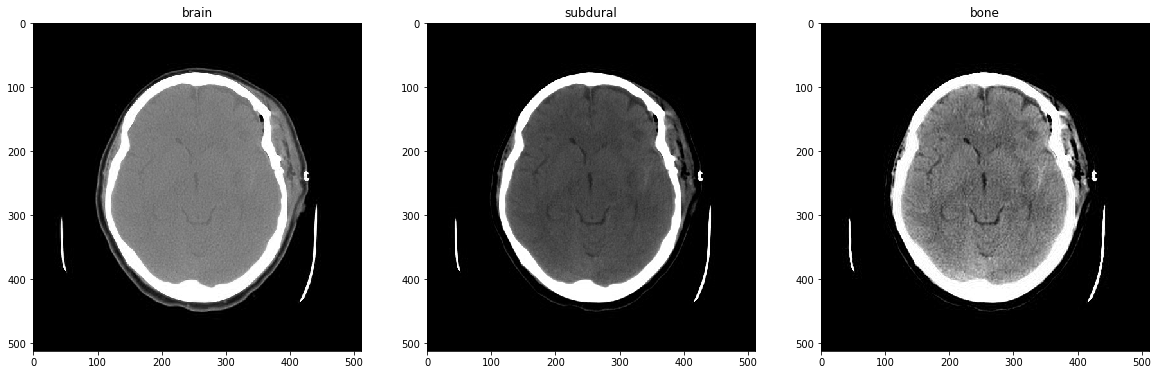

In [118]:
nm = ['brain', 'subdural','bone']
f, axarr = plt.subplots(1,3, figsize=(20, 10))
for i in range(3):
    axarr[i].imshow(fin[i], cmap='gray')
    axarr[i].set_title(nm[i])

In [119]:
from PIL import Image

im = Image.open('data/rsna_darraghdog/darraghdog_proc/train_ID_379d24de8.jpg')
g = im.getdata()

chan = [[],[],[]]
for j in range(3):
    for v in g:
        chan[j].append(v[j])
    
fin = np.array(chan).reshape((3, 512,512))

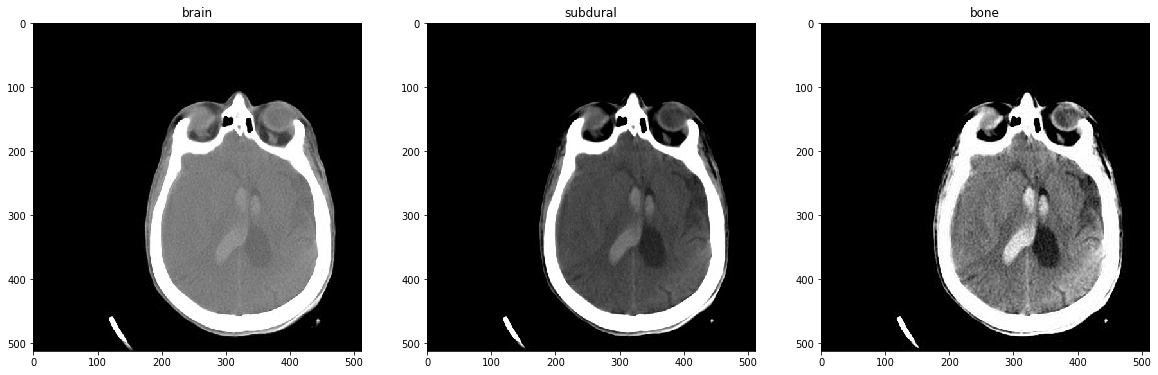

In [120]:
nm = ['brain', 'subdural','bone']
f, axarr = plt.subplots(1,3, figsize=(20, 10))
for i in range(3):
    axarr[i].imshow(fin[i], cmap='gray')
    axarr[i].set_title(nm[i])